# What drives the price of a car?



# Business Objective

The primary objective is to uncover patterns, correlations, and insights that can inform the pricing strategy of a used car dealership by pinpointing the attributes that consumers value most in used cars. Specifically, the data task will involve:
Data Cleaning and Preprocessing: This step will involve handling missing values, outliers, and erroneous data entries to ensure the dataset's quality and reliability for analysis.

## Exploratory Data Analysis (EDA):
 Conducting an in-depth exploration of the dataset to understand the distribution of key variables, identify potential relationships between car features and their prices, and detect any trends or patterns.


## Import Libraries

In [11]:
# Data Manipulation
import pandas as pd
import numpy as np

# Data Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler

# Modeling
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

# Evaluation
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error

# General
import time
from random import randint
import warnings
warnings.filterwarnings("ignore")
#

Set Variables

In [56]:
sns.set_palette("pastel")  # Other options: "deep", "muted", "bright", "dark", "colorblind"
sns_palette_name = 'plasma' # rocket, mako, flare, crest, viridis, plasma, inferno, magma, cividis
sns.set_style("whitegrid")

### Load Dataset


In [57]:
# Load the dataset from Google Drive
df = pd.read_csv("/workspaces/UC-Berkeley-MLAI/Assignment_11_1/data/vehicles.csv")

### Review Data to understand the structure and features


In [14]:
df.columns

Index(['id', 'region', 'price', 'year', 'manufacturer', 'model', 'condition',
       'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'VIN',
       'drive', 'size', 'type', 'paint_color', 'state'],
      dtype='object')

### Clean Up Dataset


In [15]:
#  Drop any rows where 'type' is ( integer or float) and has NaN values

df = df.drop(df.loc[(df['type'].notnull()) & (df['type'].apply(lambda x: isinstance(x, (int, float))) & (df['type'].isnull()))].index)


### VIN Column Adjustments

In [16]:
# Drop values in 'VIN' where they are NaN

df = df.dropna(subset=['VIN'])

# Drop rows where 'VIN' value is duplicated

df = df.drop_duplicates(subset='VIN', keep='last')

# Make 'VIN' the index column

df = df.set_index('VIN')

### ID and Region Column Adjustments

In [17]:
# Drop columns in ['id', 'region']

df = df.drop(columns=['id', 'region'])

### States Column  Adjustments

In [18]:
# Cluster states into three areas

west = ['ak', 'az', 'ca', 'co', 'hi', 'id', 'mt', 'nv', 'nm', 'or', 'ut', 'wa', 'wy']
central = ['al', 'ar', 'il', 'ia', 'ks', 'ky', 'la', 'mn', 'ms', 'mo', 'ne', 'nd', 'ok', 'sd', 'tx', 'wi']
east = ['ct', 'de', 'fl', 'ga', 'in', 'me', 'md', 'ma', 'mi', 'nh', 'nj', 'ny', 'nc', 'oh', 'pa', 'ri', 'sc', 'tn', 'vt', 'va', 'wv', 'dc']


def map_state_to_area(state):
    if state in west:
        return 'west'
    elif state in central:
        return 'central'
    elif state in east:
        return 'east'
    else:
        return 'other'  # For states not categorized or missing values

df['area'] = df['state'].apply(map_state_to_area)

df['area'].value_counts()

# Now drop 'state' column

df = df.drop('state', axis=1)



### Model Column Adjustments

In [19]:
# Delete values in 'model' where value_counts < 50

df = df[~df['model'].isin(df['model'].value_counts()[df['model'].value_counts() < 50].index)]
df['model'].value_counts()

# Drop values in 'model' where they are NaN

df = df.dropna(subset=['model'])

# Clean up 'model' values that have odd text values

df['model'] = df['model'].astype(str).apply(lambda x : x.split(' ')[0])
df['model'] = df['model'].astype(str).apply(lambda x: x.split('/')[0])

df = df[~df['model'].isin(df['model'].value_counts()[df['model'].value_counts() < 50].index)]

# Display unique values in 'model'

print(df["model"].unique())

['mustang' 'sentra' 'fj' 'altima' 'frontier' 'tacoma' 'enclave'
 'silverado' 'sorento' 'pathfinder' '2500' 'terrain' 'charger' 'forte'
 '300' 'cooper' '4runner' 'cobalt' 'tahoe' 'q7' 'trax' 'hhr' 'camry' 'q50'
 'venza' 'rogue' 'elantra' 'jetta' 'explorer' 'srx' 'corolla' 'rx'
 'accent' 'e-class' 'cx-5' 'verano' 'accord' 'impala' 'grand' 'yukon'
 'murano' '3500' 'odyssey' 'optima' 'rio' 'f-150' 'x3' 'is' 'malibu'
 '1500' 'mdx' 'wrangler' 'lancer' 'f150' 'focus' 'liberty' 'es' 'cherokee'
 'escape' 'cruze' 'cr-v' 'titan' 'prius' 'trailblazer' 'fusion'
 'outlander' 'highlander' 'tl' 'juke' 'avalon' 'compass' 'edge' 'soul'
 'acadia' 'sonic' 'journey' 'traverse' 'santa' 's60' 'fiesta' 'versa'
 'lacrosse' 'rdx' 'sedona' 'pilot' 'maxima' 'durango' 'veloster' 'sonata'
 'patriot' 'tlx' 'sportage' 'xv' 'passat' 'civic' 'c-class' 'xterra'
 'taurus' 'x5' 'yaris' 'armada' 'suburban' 'tundra' 'sierra' 'escalade'
 'mkc' 'renegade' 'town' 'colorado' 'lucerne' 'rav4' 'sienna' '3' 'pt'
 'outback' 'expres

### Year Column  Adjustments

In [20]:
# Drop values in 'year' where they are NaN

df = df.dropna(subset=['year'])

# Convert 'year' to integer
df['year'] = df['year'].fillna(0)
df['year'] = df['year'].astype('int64')

# Drop where year < 2000
df = df.drop(df.loc[df['year'] < 2000].index)

### Price Column Adjustments

In [21]:
# Drop values in 'price' where they are NaN

df = df.dropna(subset=['price'])

# Drop where 'price' < 1,000 or 'price' > 80,000

df = df.drop(df.loc[df['price'] < 1000].index)
df = df.drop(df.loc[df['price'] > 80000].index)

### Odometer Column Adjustments

In [22]:
# Drop values in odometer where they are NaN

df = df.dropna(subset=['odometer'])

# Convert 'odometer' to int64

df = df.dropna(subset=['odometer'])
df['odometer'] = df['odometer'].astype('int64')

#  Drop where 'odometer' > 200000

df = df.drop(df.loc[df['odometer'] > 200000].index)

# Now create 10 buckets that are made up of dividing the range by 10
min_value = df['odometer'].min()
max_value = df['odometer'].max()

# Calculate the range width for each bucket
range_width = (max_value - min_value) / 10

# Create the bins edges
bins = np.arange(min_value, max_value, range_width)

# Make sure to include the max value by appending it
bins = np.append(bins, max_value)

# Create labels based on the lower bound of each bin
labels = bins[:-1].astype(int)  # Convert to int for cleaner labels, omit the last edge

# Use pd.cut() to create the buckets and label them
df['odometer_range'] = pd.cut(df['odometer'], bins=bins, labels=labels, include_lowest=True)

# DDrop odometer column

df = df.drop(columns=['odometer'])

### Fuel Column Adjustments

In [23]:
df = df[~df['fuel'].isin(df['fuel'].value_counts()[df['fuel'].value_counts() < 100].index)]

print(df['fuel'].value_counts())

fuel
gas         48366
diesel       1925
other        1887
hybrid        552
electric      125
Name: count, dtype: int64


### Cylinders Column Adjustments

In [24]:
# Drop values in 'cylinders' where they are NaN

df = df.dropna(subset=['cylinders'])

# Drop where values in 'cylinders' in ['other', '3 cylinders', '12 cylinders', '5 cylinders', '10 cylinders']]

df = df[~df["cylinders"].isin(['other', '3 cylinders', '5 cylinders', '10 cylinders', '12 cylinders'])]


### Title Status Column Adjustments

In [25]:
# Rename 'title_status' to 'title' for brevity
df.rename(columns={'title_status': 'title'}, inplace=True)

# Drop values in 'title' where they are NaN

df = df.dropna(subset=['title'])

# Drop where 'title' in [ rebuilt, salvage, lien, missing, parts only]

df = df.drop(df.loc[df['title'].isin(['rebuilt','salvage', 'lien', 'missing', 'parts only'])].index)

# Drop the title column because we are only interested in cars with good titles

df = df.drop('title', axis=1)


### Condition Column Adjustments

In [26]:
# Drop values in 'condition' where they are NaN

df = df.dropna(subset=['condition'])

# Drop where 'condition' == salvage

df = df.drop(df.loc[df['condition'] == 'salvage'].index)

### Transmission Column Adjustments

In [27]:
# Drop values in transmission where they are NaN

df = df.dropna(subset=['transmission'])

# Drop where transmission = other

df = df.drop(df.loc[df['transmission'] == 'other'].index)

### Drive Column Adjustments

In [28]:
# Drop values in drive where they are NaN

df = df.dropna(subset=['drive'])

# Change values in 'drive' from '4wd' to 'fwd'

df['drive'] = df['drive'].replace('4wd', 'fwd')

### Type (of vehicle) Column Adjustments

In [29]:
# Drop values in type where they are NaN

df = df.dropna(subset=['type'])

# Drop 'type' values = bus

df = df.drop(df.loc[df['type'] == 'bus'].index)

# Reduce the number of types

df['type'] = df['type'].replace(['mini-van', 'van', 'offroad', 'wagon', 'convertible'], 'other')
print(df['type'].value_counts())

type
sedan        4904
SUV          4544
truck        2006
other        1592
pickup       1158
hatchback     513
coupe         436
Name: count, dtype: int64


### Color Column Adjustments

In [30]:
# Rename paint_color to color for brevity

df.rename(columns={'paint_color': 'color'}, inplace=True)

# Drop values in paint where they are NaN

df = df.dropna(subset=['color'])

# In 'paint' column, change values green, brown, yellow, orange, purple into 'other'

df['color'] = df['color'].replace(['green', 'brown', 'yellow', 'orange', 'purple'], 'other')
# prompt: Change color values that are == 'custom' to 'other'

df['color'] = df['color'].replace('custom', 'other')

print(df['color'].value_counts())

color
white     3087
black     2659
silver    2201
grey      1910
blue      1496
other     1243
red       1225
Name: count, dtype: int64


### Size Column Adjustments

In [31]:
# Drop values in 'size' where they are NaN

df = df.dropna(subset=['size'])

print(df['size'].value_counts())


size
full-size      5399
mid-size       2799
compact        1115
sub-compact     182
Name: count, dtype: int64


### Manufacturer Column Adjustments

In [32]:
# Drop values in manufacturer where they are NaN

df = df.dropna(subset=['manufacturer'])

# Drop rows from 'manufacturer' where the value_count() < 100

df = df[~df['manufacturer'].isin(df['manufacturer'].value_counts()[df['manufacturer'].value_counts() < 100].index)]

print(df['manufacturer'].value_counts())

manufacturer
ford          1758
chevrolet     1443
toyota         995
honda          707
nissan         558
jeep           461
gmc            414
ram            409
hyundai        312
dodge          282
subaru         277
kia            210
volkswagen     203
chrysler       194
bmw            166
cadillac       122
audi           120
buick          114
lexus          113
Name: count, dtype: int64


### Print Value Counts of Each Column

Create a subset of Top 10 Manufacturers and Models for use in subsequent Plots

In [33]:
# There are too many manufacturers and models, so just get the top 10 of each
top_brands = df['manufacturer'].value_counts().nlargest(10).index
top_models = df['model'].value_counts().nlargest(10).index
filtered_df = (df[df['manufacturer'].isin(top_brands)] )
filtered_df = (filtered_df[filtered_df['model'].isin(top_models)] )
filtered_df.head()

,price,year,manufacturer,model,condition,cylinders,fuel,transmission,drive,size,type,color,area,odometer_range
VIN,,,,,,,,,,,,,,
4T1BD1FK4DU076083,10800,2013,toyota,camry,excellent,4 cylinders,hybrid,automatic,fwd,mid-size,sedan,grey,central,140000
1C6RR6GG6FS645954,16900,2015,ram,1500,good,6 cylinders,gas,automatic,rwd,full-size,pickup,silver,central,80000
1C4RJEAG6HC782831,23900,2017,jeep,grand,good,6 cylinders,gas,automatic,rwd,full-size,SUV,black,central,40000
JHMCP26468C032426,5950,2008,honda,accord,excellent,4 cylinders,gas,automatic,fwd,mid-size,sedan,grey,central,180000
1C6RR7GT0DS689917,17900,2013,ram,1500,good,8 cylinders,gas,automatic,fwd,full-size,truck,white,central,140000


In [34]:
# Iterate over each column in the DataFrame
for column in df.columns:
    # Check if the column is of object type (commonly used for categorical data)
    if df[column].dtype == 'object':
        print(f"Column: {column}")
        print(df[column].value_counts())
        print("\n")

Column: manufacturer
manufacturer
ford          1758
chevrolet     1443
toyota         995
honda          707
nissan         558
jeep           461
gmc            414
ram            409
hyundai        312
dodge          282
subaru         277
kia            210
volkswagen     203
chrysler       194
bmw            166
cadillac       122
audi           120
buick          114
lexus          113
Name: count, dtype: int64


Column: model
model
silverado    583
f-150        454
1500         269
grand        253
sierra       229
            ... 
ecosport       4
sport          2
xt5            2
leaf           1
f-250sd        1
Name: count, Length: 172, dtype: int64


Column: condition
condition
excellent    5067
good         2782
like new      887
fair           83
new            39
Name: count, dtype: int64


Column: cylinders
cylinders
4 cylinders    3673
6 cylinders    2988
8 cylinders    2197
Name: count, dtype: int64


Column: fuel
fuel
gas         8359
diesel       374
hybrid       11

### Print Min, Max, Mean of Each Column

In [35]:
# Iterate over each column in the DataFrame
for column in df.columns:
    # Check if the column is numeric
    if pd.api.types.is_numeric_dtype(df[column]):
        print(f"Column: {column}")
        print(f"Min: {df[column].min()}")
        print(f"Max: {df[column].max()}")
        print(f"Mean: {df[column].mean()}")
        print("\n")

Column: price
Min: 1000
Max: 79995
Mean: 15955.679160081283


Column: year
Min: 2000
Max: 2021
Mean: 2012.1365996839015




#### Violin Plot of All Features

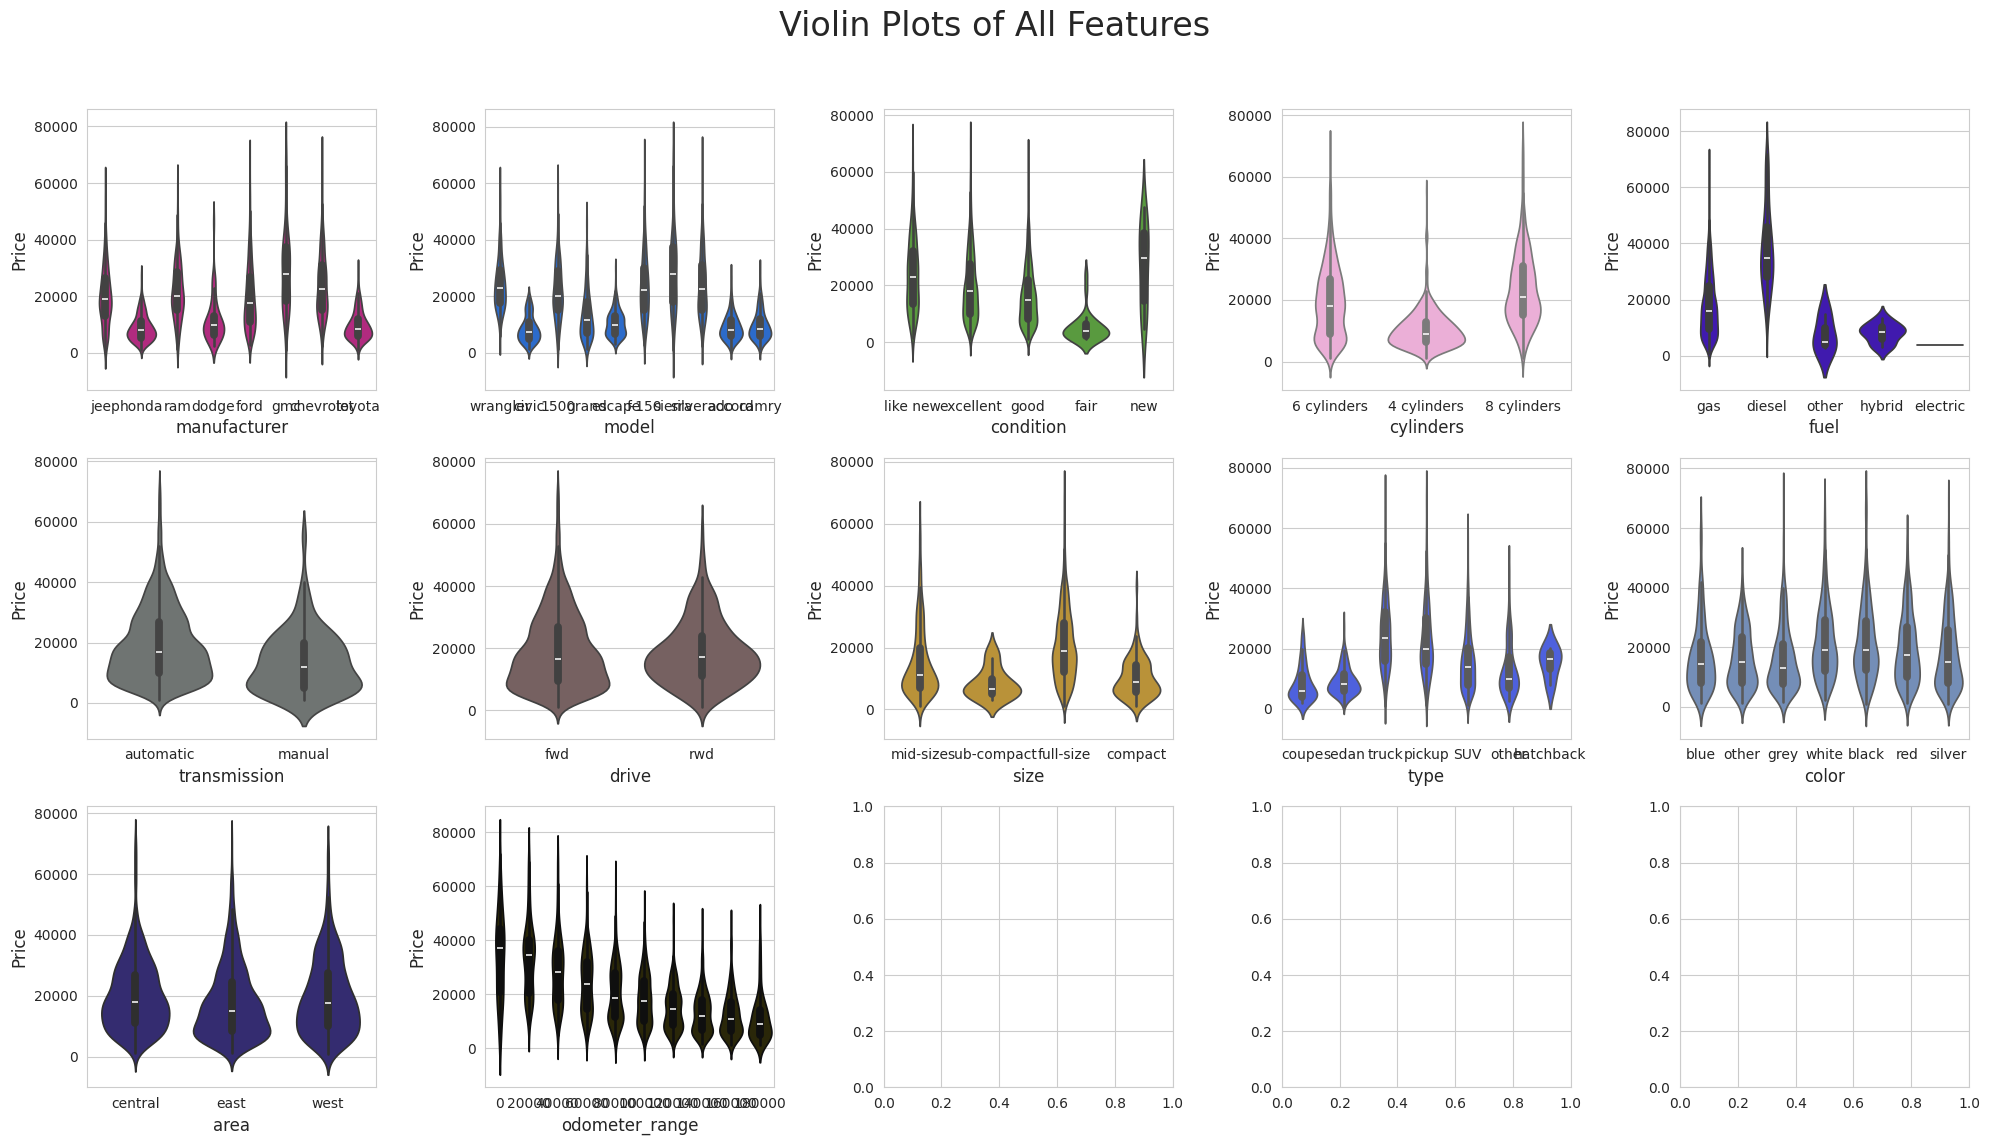

<Figure size 640x480 with 0 Axes>

In [36]:
selected_cols = ['manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'transmission', 'drive', 'size', 'type', 'color', 'area', 'odometer_range']

colors = ['mediumvioletred']
for i in range(len(selected_cols)):
    colors.append('#%06X' % randint(0, 0xFFFFFF))

num_subplots = len(selected_cols)
num_rows = (num_subplots - 1) // 5 + 1
num_cols = min(5, num_subplots)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 4), facecolor='white')
fig.suptitle("Violin Plots of All Features", size=24)

for i in range(num_rows):
    for j in range(num_cols):
        idx = i * num_cols + j
        if idx < num_subplots:
            sns.violinplot(data = filtered_df,x = filtered_df[selected_cols[idx]], y = df['price'], ax=axes[i,j], color=colors[idx])
            axes[i, j].set_xlabel(selected_cols[idx], fontsize=12)  # Set x-axis label font size
            axes[i, j].set_ylabel("Price", fontsize=12)  # Set y-axis label font size

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
plt.savefig("Violin Plots of All Features.png", dpi=300)


From the violin plot, we can infer the following conclusions about the distribution of car prices with respect to different features:
#####Manufacturer:
 There is variation in price distribution among different manufacturers. Some manufacturers have a wider range of prices, while others have a more concentrated distribution, indicating that certain manufacturers may cater to different market segments.
#####Model:
 The price distribution varies significantly across different car models. Some models have a wide distribution, suggesting a range of options at different price points, while others are more concentrated.
#####Condition:
Cars in excellent condition tend to have a higher median price and a wider distribution, indicating a range of prices within the 'excellent' category. Cars in lower condition categories have a more concentrated distribution, with lower median prices.
#####Transmission:
 Automatic transmission cars have a wider price distribution compared to manual transmission cars, which could suggest a higher demand or a greater variety of features and models available with automatic transmissions.
#####Drive:
 The distribution of prices for cars with different drive types (fwd, rwd) shows variation, with some drive types having a wider range of prices.
#####Size:
 Compact cars have a more concentrated price distribution, while full-size cars have a wider distribution, indicating a greater variety of price points within the full-size category.
#####Cylinders:
 The number of cylinders is associated with different price distributions. Cars with more cylinders tend to have a higher median price and a wider distribution, which may reflect higher performance or luxury models.
#####Type:
 Different car types (sedan, SUV, truck, etc.) have distinct price distributions, with some types having a wider range of prices, which could be due to differences in utility, features, and market demand.
#####Color:
 The distribution of prices also varies by color, with some colors having a wider distribution than others, which might reflect consumer preferences or the availability of certain colors in higher-end models.
#####Area:
 The area feature shows different price distributions, which could indicate regional variations in car prices due to factors like demand, economic conditions, or availability.
#####Odometer Range:
 Cars with different odometer readings show varying price distributions, with newer cars (lower odometer readings) generally having higher prices.
#####Conclusion
These insights from the violin plot can be valuable for understanding the factors that influence car prices.
Further analysis will determine which features have the most impact on car prices.


### Plot Price into 20 bins

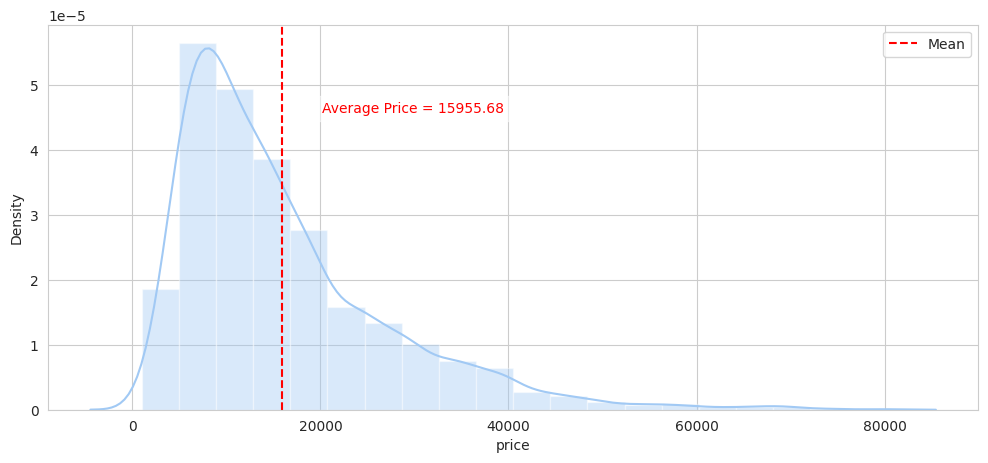

<Figure size 640x480 with 0 Axes>

In [37]:
sns.set_style("whitegrid")
plt.figure(figsize=(12,5))

plotd = sns.distplot(df.price, kde=True, bins=20)

mean_line = plt.axvline(df.price.mean(), c='red', linestyle='dashed', label='Mean')

plt.text(0.49, 0.8, f'Average Price = {df.price.mean():.2f}', transform=plt.gca().transAxes, color='red', fontsize=10,
         verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white',alpha=0.5))
plt.legend()
plt.show()
plt.savefig("Average Price of Car.png", dpi=300)

The distribution of prices has a peak to the left of the mean price of $15,955.

The distribution appears to be right-skewed, with a long tail extending towards higher prices. This suggests that while most of the cars are clustered around the mean price, there is a significant number of cars with higher prices, which could represent luxury or high-performance vehicles.

The plot does not show a clear indication of a bimodal distribution, which would be characterized by two distinct peaks. Instead, there is one clear peak and a gradual decline in density as the price increases.

The presence of a long tail towards the higher prices suggests that there are  a smaller cluster of higher-priced cars.


### Plot Top Manufacturers

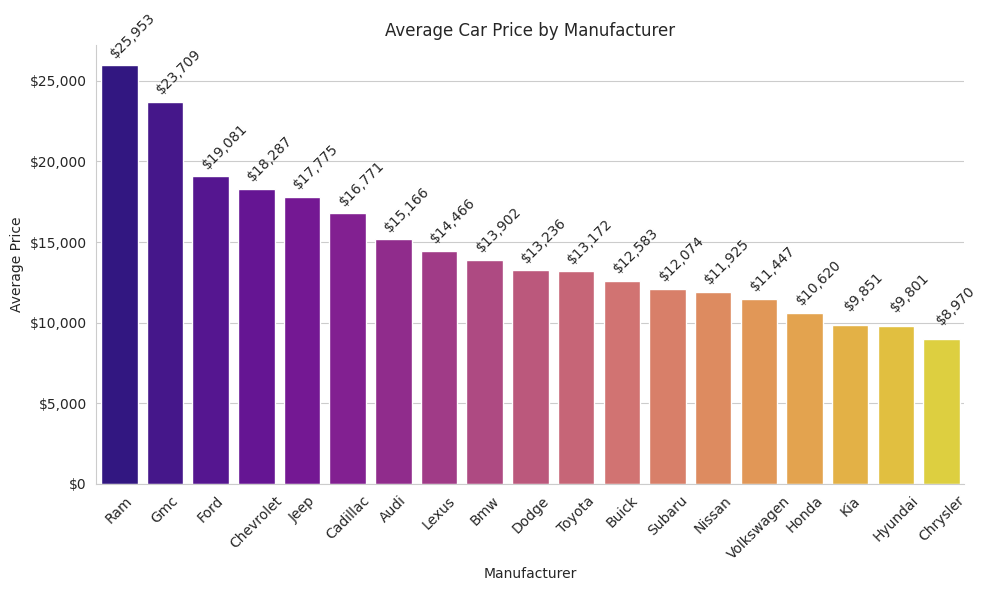

<Figure size 640x480 with 0 Axes>

In [38]:
average_price_per_manufacturer = df.groupby('manufacturer')['price'].mean().reset_index()

# Sort the manufacturers by average price in descending order
average_price_per_manufacturer_sorted = average_price_per_manufacturer.sort_values(by='price', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))  # Optional: Adjusts the size of the plot
ax = sns.barplot(data=average_price_per_manufacturer_sorted, x='manufacturer', y='price', palette=sns_palette_name)
plt.title('Average Car Price by Manufacturer')
plt.xlabel('Manufacturer')
plt.ylabel('Average Price')
plt.xticks(rotation=45)

# Get current axis tick labels
xlabels = [label.get_text() for label in plt.gca().get_xticklabels()]
ylabels = [label.get_text() for label in plt.gca().get_yticklabels()]


# Format each number with commas and a dollar sign
y_formatted_numbers = [f'${int(num):,.0f}' for num in ylabels]

# Format each number with commas separating the thousands
#_formatted_numbers = ['{:,}'.format(int(num)) for num in xlabels]

# Format each number with commas and a dollar sign
y_formatted_numbers = [f'${int(num):,.0f}' for num in ylabels]

# Capitalize each label
capitalized_labels = [label.capitalize() for label in xlabels]

# Set the modified labels back on the x-axis
plt.gca().set_xticklabels(capitalized_labels)
plt.gca().set_yticklabels(y_formatted_numbers)

plt.xticks(rotation=45)  # Optional: Rotate labels to avoid overlap

# Annotate each bar with the value
for p in ax.patches:
    ax.annotate('${:,.0f}'.format(p.get_height()),
    (p.get_x() + p.get_width() / 2., p.get_height()),
    ha = 'center', va = 'top',
    xytext = (10, 40),
    textcoords = 'offset points',
    rotation=45)


# Despine the plot and show the final result
sns.despine()
plt.tight_layout()
plt.show()
plt.savefig("Average Car Price by Manufacturer.png", dpi=300)


Plot Average Price by Model

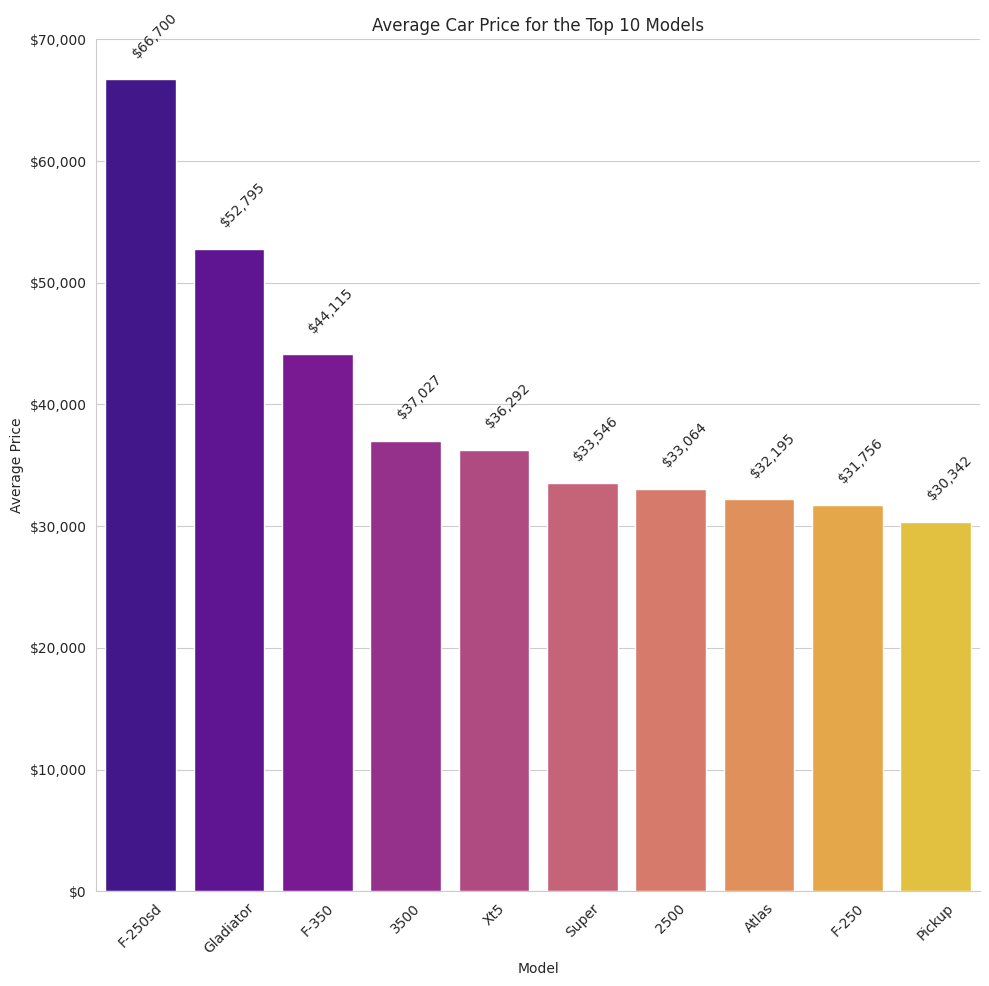

<Figure size 640x480 with 0 Axes>

In [39]:
average_price_by_model = df.groupby('model')['price'].mean().reset_index()

# Sort the Model by average price in descending order
average_price_by_model_sorted = average_price_by_model.sort_values(by='price', ascending=False)

# Limit to the top 10 only
average_price_by_model_sorted = average_price_by_model_sorted[:10]

# Plotting
plt.figure(figsize=(10, 10))  # Optional: Adjusts the size of the plot
ax = sns.barplot(data=average_price_by_model_sorted, x='model', y='price', palette=sns_palette_name)
plt.title('Average Car Price for the Top 10 Models')
plt.xlabel('Model')
plt.ylabel('Average Price')
plt.xticks(rotation=45)

# Get current axis tick labels
xlabels = [label.get_text() for label in plt.gca().get_xticklabels()]
ylabels = [label.get_text() for label in plt.gca().get_yticklabels()]


# Format each number with commas and a dollar sign
y_formatted_numbers = [f'${int(num):,.0f}' for num in ylabels]

# Format each number with commas separating the thousands
#_formatted_numbers = ['{:,}'.format(int(num)) for num in xlabels]

# Capitalize each label
capitalized_labels = [label.capitalize() for label in xlabels]

# Set the modified labels back on the x-axis
plt.gca().set_xticklabels(capitalized_labels)
plt.gca().set_yticklabels(y_formatted_numbers)

plt.xticks(rotation=45)   # Optional: Rotate labels to avoid overlap

# Annotate each bar with the value

for p in ax.patches:
    ax.annotate('${:,.0f}'.format(p.get_height()),
    (p.get_x() + p.get_width() / 2., p.get_height()),
    ha = 'center', va = 'top',
    xytext = (10, 50),
    textcoords = 'offset points',
    rotation=45
                )

# Despine the plot and show the final result
sns.despine()
plt.tight_layout()
plt.show()
plt.savefig("Average Car Price by Model.png", dpi=300)

### Mean Price by Odometer Range

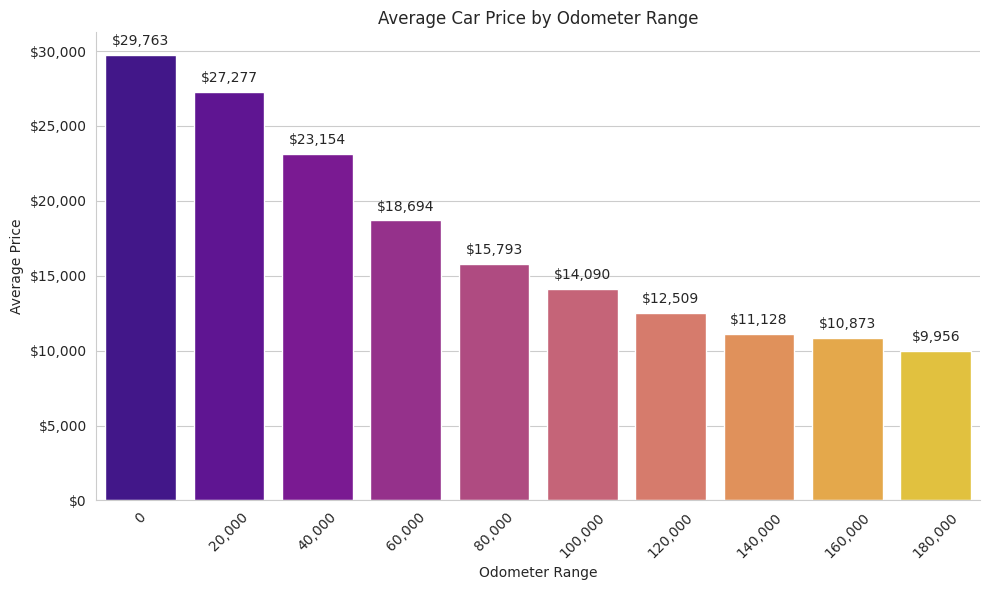

<Figure size 640x480 with 0 Axes>

In [40]:
# Sort the Odometer Ranges by average price in descending order
average_price_per_odometer_range = df.groupby('odometer_range')['price'].mean().reset_index()

average_price_per_odometer_range_sorted = average_price_per_odometer_range.sort_values(by='price', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))  # Optional: Adjusts the size of the plot
ax = sns.barplot(data=average_price_per_odometer_range_sorted, x='odometer_range', y='price', palette=sns_palette_name)
plt.title('Average Car Price by Odometer Range')
plt.xlabel('Odometer Range')
plt.ylabel('Average Price')
plt.xticks(rotation=45)


# Get current x-axis tick labels
xlabels = [label.get_text() for label in plt.gca().get_xticklabels()]
ylabels = [label.get_text() for label in plt.gca().get_yticklabels()]


# Format each number with commas separating the thousands
x_formatted_numbers = ['{:,}'.format(int(num)) for num in xlabels]
# Format each number with commas and a dollar sign
y_formatted_numbers = [f'${int(num):,.0f}' for num in ylabels]


# Set the modified labels back on the x-axis
plt.gca().set_xticklabels(x_formatted_numbers)
plt.gca().set_yticklabels(y_formatted_numbers)

# Annotate each bar with the value
for p in ax.patches:
    #ax.annotate(format(p.get_height(), '${:,.2f}'),
    ax.annotate('${:,.0f}'.format(p.get_height()),
    (p.get_x() + p.get_width() / 2., p.get_height()),
    ha = 'center', va = 'center',
    xytext = (0, 10),
    textcoords = 'offset points')

# Despine the plot and show the final result
sns.despine()
plt.tight_layout()
plt.show()
plt.savefig("Average Car Price by Odometer Range.png", dpi=300)

### Mean Price by Color

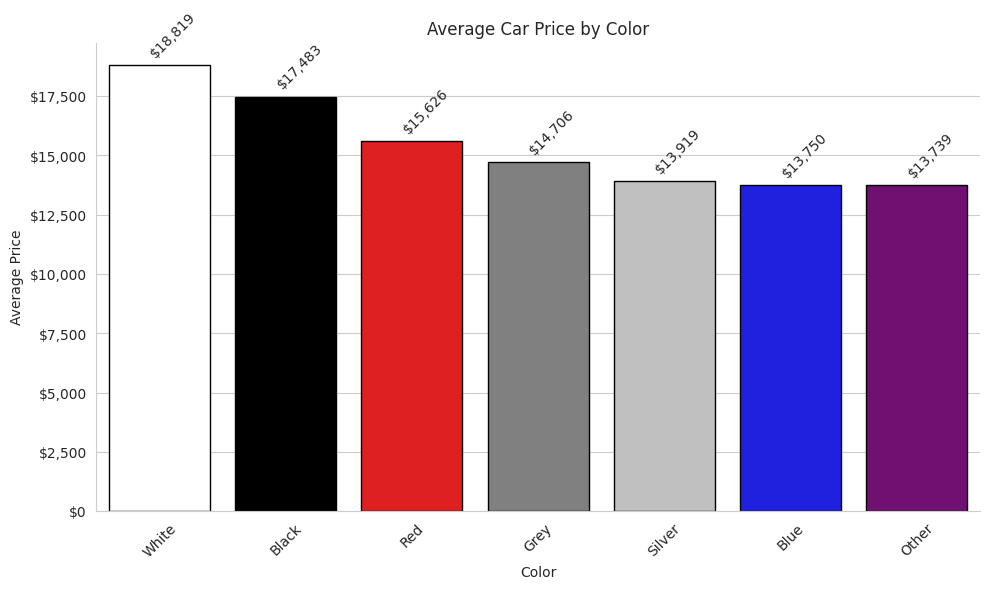

<Figure size 640x480 with 0 Axes>

In [41]:
average_price_by_color = df.groupby('color')['price'].mean().reset_index()

# Sort the color by average price in descending order
average_price_by_color_sorted = average_price_by_color.sort_values(by='price', ascending=False)

special_palette=['white','black','red','grey', 'silver', 'blue', 'purple']

# Plotting
plt.figure(figsize=(10, 6))  # Optional: Adjusts the size of the plot
ax = sns.barplot(data=average_price_by_color_sorted, x='color', y='price', palette=special_palette, edgecolor='black')
plt.title('Average Car Price by Color')
plt.xlabel('Color')
plt.ylabel('Average Price')
plt.xticks(rotation=45)

# Get current axis tick labels
xlabels = [label.get_text() for label in plt.gca().get_xticklabels()]
ylabels = [label.get_text() for label in plt.gca().get_yticklabels()]


# Format each number with commas and a dollar sign
y_formatted_numbers = [f'${int(num):,.0f}' for num in ylabels]

# Format each number with commas separating the thousands
#_formatted_numbers = ['{:,}'.format(int(num)) for num in xlabels]

# Capitalize each label
capitalized_labels = [label.capitalize() for label in xlabels]

# Set the modified labels back on the x-axis
plt.gca().set_xticklabels(capitalized_labels)
plt.gca().set_yticklabels(y_formatted_numbers)

plt.xticks(rotation=45)  # Optional: Rotate labels to avoid overlap

# Annotate each bar with the value
for p in ax.patches:
    ax.annotate('${:,.0f}'.format(p.get_height()),
    (p.get_x() + p.get_width() / 2., p.get_height()),
    ha = 'center', va = 'top',
    xytext = (10, 40),
    textcoords = 'offset points',
    rotation=45)

# Despine the plot and show the final result
sns.despine()
plt.tight_layout()
plt.show()
plt.savefig("Average Car Price by Color.png", dpi=300)


### Mean Price by Type of Vehicle

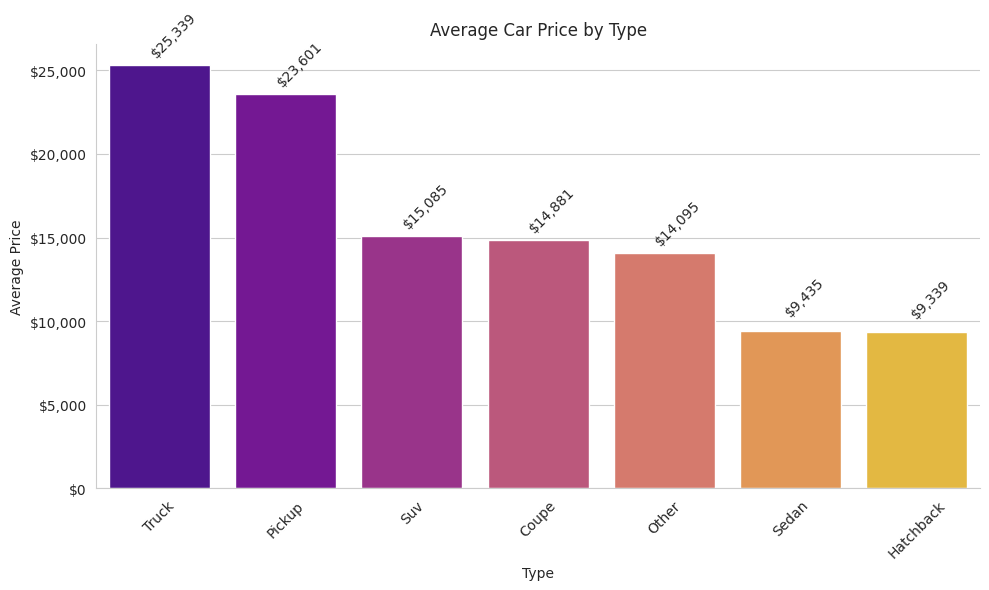

<Figure size 640x480 with 0 Axes>

In [42]:
average_price_by_type = df.groupby('type')['price'].mean().reset_index()

# Sort by average price in descending order
average_price_by_type_sorted = average_price_by_type.sort_values(by='price', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))  # Optional: Adjusts the size of the plot
ax = sns.barplot(data=average_price_by_type_sorted, x='type', y='price', palette=sns_palette_name)
plt.title('Average Car Price by Type')
plt.xlabel('Type')
plt.ylabel('Average Price')
plt.xticks(rotation=45)

# Get current axis tick labels
xlabels = [label.get_text() for label in plt.gca().get_xticklabels()]
ylabels = [label.get_text() for label in plt.gca().get_yticklabels()]


# Format each number with commas and a dollar sign
y_formatted_numbers = [f'${int(num):,.0f}' for num in ylabels]

# Format each number with commas separating the thousands
#_formatted_numbers = ['{:,}'.format(int(num)) for num in xlabels]

# Capitalize each label
capitalized_labels = [label.capitalize() for label in xlabels]

# Set the modified labels back on the x-axis
plt.gca().set_xticklabels(capitalized_labels)
plt.gca().set_yticklabels(y_formatted_numbers)

plt.xticks(rotation=45)  # Optional: Rotate labels to avoid overlap

# Annotate each bar with the value
for p in ax.patches:
    ax.annotate('${:,.0f}'.format(p.get_height()),
    (p.get_x() + p.get_width() / 2., p.get_height()),
    ha = 'center', va = 'top',
    xytext = (10, 40),
    textcoords = 'offset points',
    rotation=45)

# Despine the plot and show the final result
sns.despine()
plt.tight_layout()
plt.show()
plt.savefig("Average Car Price by Type.png", dpi=300)

### Mean Price per Geographical Area

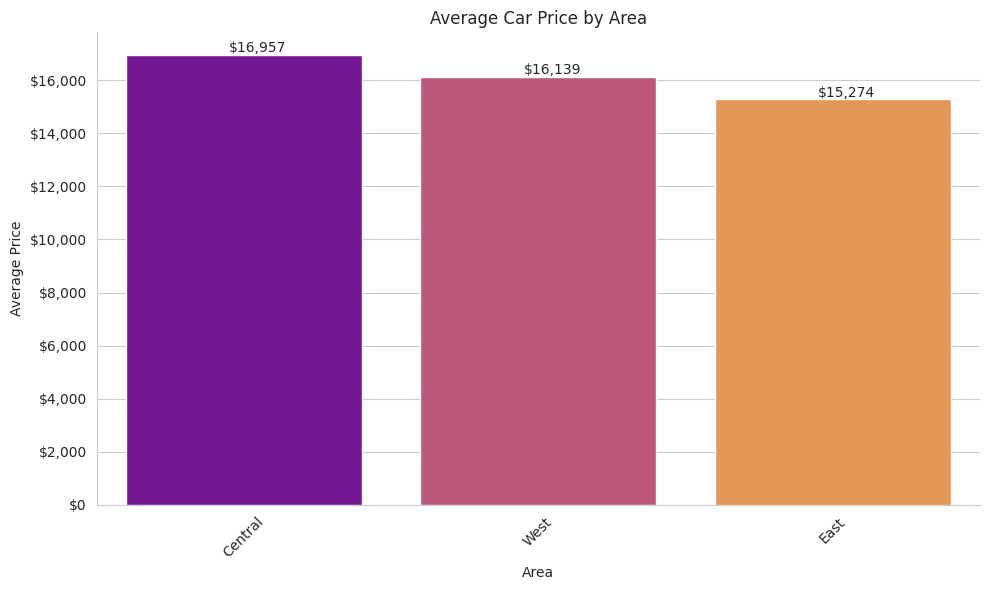

<Figure size 640x480 with 0 Axes>

In [43]:
average_price_by_Area = df.groupby('area')['price'].mean().reset_index()

# Sort the Area by average price in descending order
average_price_by_Area_sorted = average_price_by_Area.sort_values(by='price', ascending=False)


# Plotting
plt.figure(figsize=(10, 6))  # Optional: Adjusts the size of the plot
ax = sns.barplot(data=average_price_by_Area_sorted, x='area', y='price', palette=sns_palette_name)
plt.title('Average Car Price by Area')
plt.xlabel('Area')
plt.ylabel('Average Price')
plt.xticks(rotation=45)

# Get current axis tick labels
xlabels = [label.get_text() for label in plt.gca().get_xticklabels()]
ylabels = [label.get_text() for label in plt.gca().get_yticklabels()]


# Format each number with commas and a dollar sign
y_formatted_numbers = [f'${int(num):,.0f}' for num in ylabels]

# Format each number with commas separating the thousands
#_formatted_numbers = ['{:,}'.format(int(num)) for num in xlabels]

# Capitalize each label
capitalized_labels = [label.capitalize() for label in xlabels]

# Set the modified labels back on the x-axis
plt.gca().set_xticklabels(capitalized_labels)
plt.gca().set_yticklabels(y_formatted_numbers)

plt.xticks(rotation=45)  # Optional: Rotate labels to avoid overlap

# Annotate each bar with the value
for p in ax.patches:
    ax.annotate('${:,.0f}'.format(p.get_height()),
    (p.get_x() + p.get_width() / 2., p.get_height()),
    ha = 'center', va = 'top',
    xytext = (10, 10),
    textcoords = 'offset points',
    #rotation=45
                )

# Despine the plot and show the final result
sns.despine()
plt.tight_layout()
plt.show()
plt.savefig("Average Car Price by Area.png", dpi=300)

### Plot Average Price by Fuel

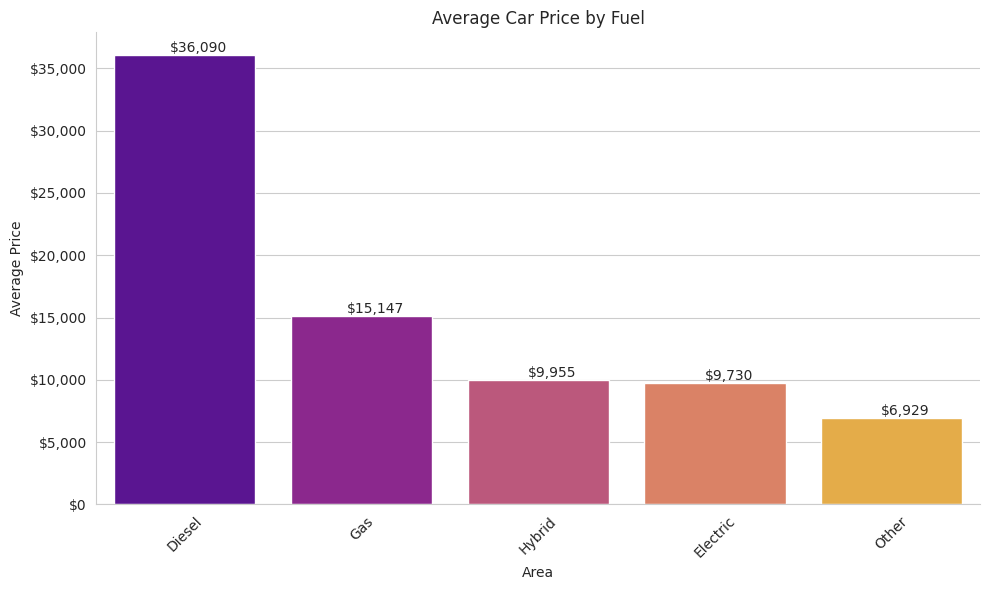

<Figure size 640x480 with 0 Axes>

In [44]:
average_price_by_fuel = df.groupby('fuel')['price'].mean().reset_index()

# Sort the Fuel by average price in descending order
average_price_by_fuel_sorted = average_price_by_fuel.sort_values(by='price', ascending=False)


# Plotting
plt.figure(figsize=(10, 6))  # Optional: Adjusts the size of the plot
ax = sns.barplot(data=average_price_by_fuel_sorted, x='fuel', y='price', palette=sns_palette_name)
plt.title('Average Car Price by Fuel')
plt.xlabel('Area')
plt.ylabel('Average Price')
plt.xticks(rotation=45)

# Get current axis tick labels
xlabels = [label.get_text() for label in plt.gca().get_xticklabels()]
ylabels = [label.get_text() for label in plt.gca().get_yticklabels()]


# Format each number with commas and a dollar sign
y_formatted_numbers = [f'${int(num):,.0f}' for num in ylabels]

# Format each number with commas separating the thousands
#_formatted_numbers = ['{:,}'.format(int(num)) for num in xlabels]

# Capitalize each label
capitalized_labels = [label.capitalize() for label in xlabels]

# Set the modified labels back on the x-axis
plt.gca().set_xticklabels(capitalized_labels)
plt.gca().set_yticklabels(y_formatted_numbers)

plt.xticks(rotation=45)  # Optional: Rotate labels to avoid overlap

# Annotate each bar with the value
for p in ax.patches:
    ax.annotate('${:,.0f}'.format(p.get_height()),
    (p.get_x() + p.get_width() / 2., p.get_height()),
    ha = 'center', va = 'top',
    xytext = (10, 10),
    textcoords = 'offset points',
    #rotation=45
                )

# Despine the plot and show the final result
sns.despine()
plt.tight_layout()
plt.show()
plt.savefig("Average Car Price by Fuel.png", dpi=300)

### Plot Average Price by Size

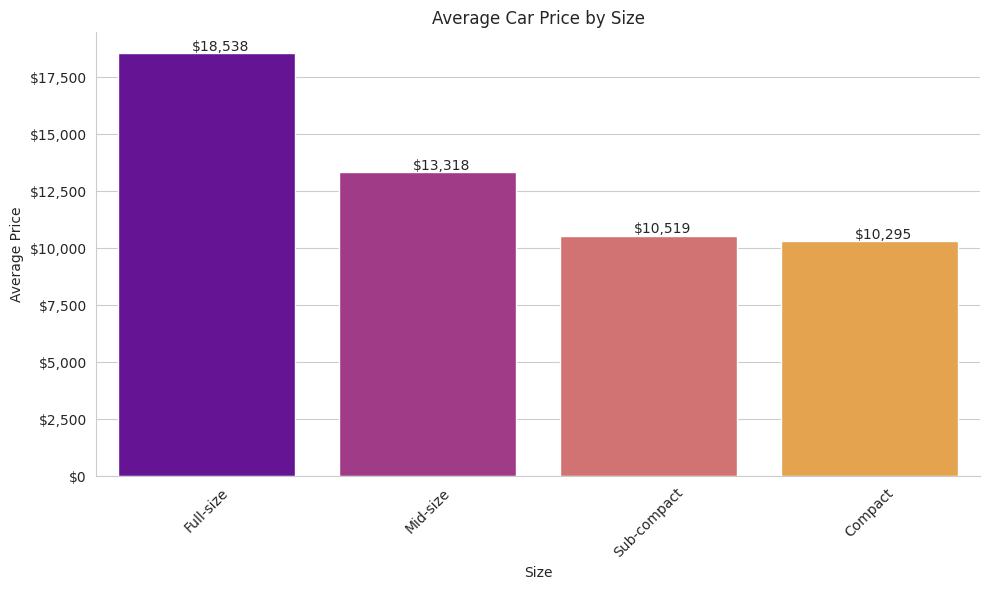

<Figure size 640x480 with 0 Axes>

In [45]:
average_price_by_size = df.groupby('size')['price'].mean().reset_index()

# Sort the Size by average price in descending order
average_price_by_size_sorted = average_price_by_size.sort_values(by='price', ascending=False)


# Plotting
plt.figure(figsize=(10, 6))  # Optional: Adjusts the size of the plot
ax = sns.barplot(data=average_price_by_size_sorted, x='size', y='price', palette=sns_palette_name)
plt.title('Average Car Price by Size')
plt.xlabel('Size')
plt.ylabel('Average Price')
plt.xticks(rotation=45)

# Get current axis tick labels
xlabels = [label.get_text() for label in plt.gca().get_xticklabels()]
ylabels = [label.get_text() for label in plt.gca().get_yticklabels()]


# Format each number with commas and a dollar sign
y_formatted_numbers = [f'${int(num):,.0f}' for num in ylabels]

# Format each number with commas separating the thousands
#_formatted_numbers = ['{:,}'.format(int(num)) for num in xlabels]

# Capitalize each label
capitalized_labels = [label.capitalize() for label in xlabels]

# Set the modified labels back on the x-axis
plt.gca().set_xticklabels(capitalized_labels)
plt.gca().set_yticklabels(y_formatted_numbers)

plt.xticks(rotation=45)  # Optional: Rotate labels to avoid overlap

# Annotate each bar with the value
for p in ax.patches:
    ax.annotate('${:,.0f}'.format(p.get_height()),
    (p.get_x() + p.get_width() / 2., p.get_height()),
    ha = 'center', va = 'top',
    xytext = (10, 10),
    textcoords = 'offset points',
    #rotation=45
                )

# Despine the plot and show the final result
sns.despine()
plt.tight_layout()
plt.show()
plt.savefig("Average Car Price by Size.png", dpi=300)

### Plot Average Price for Each Feature

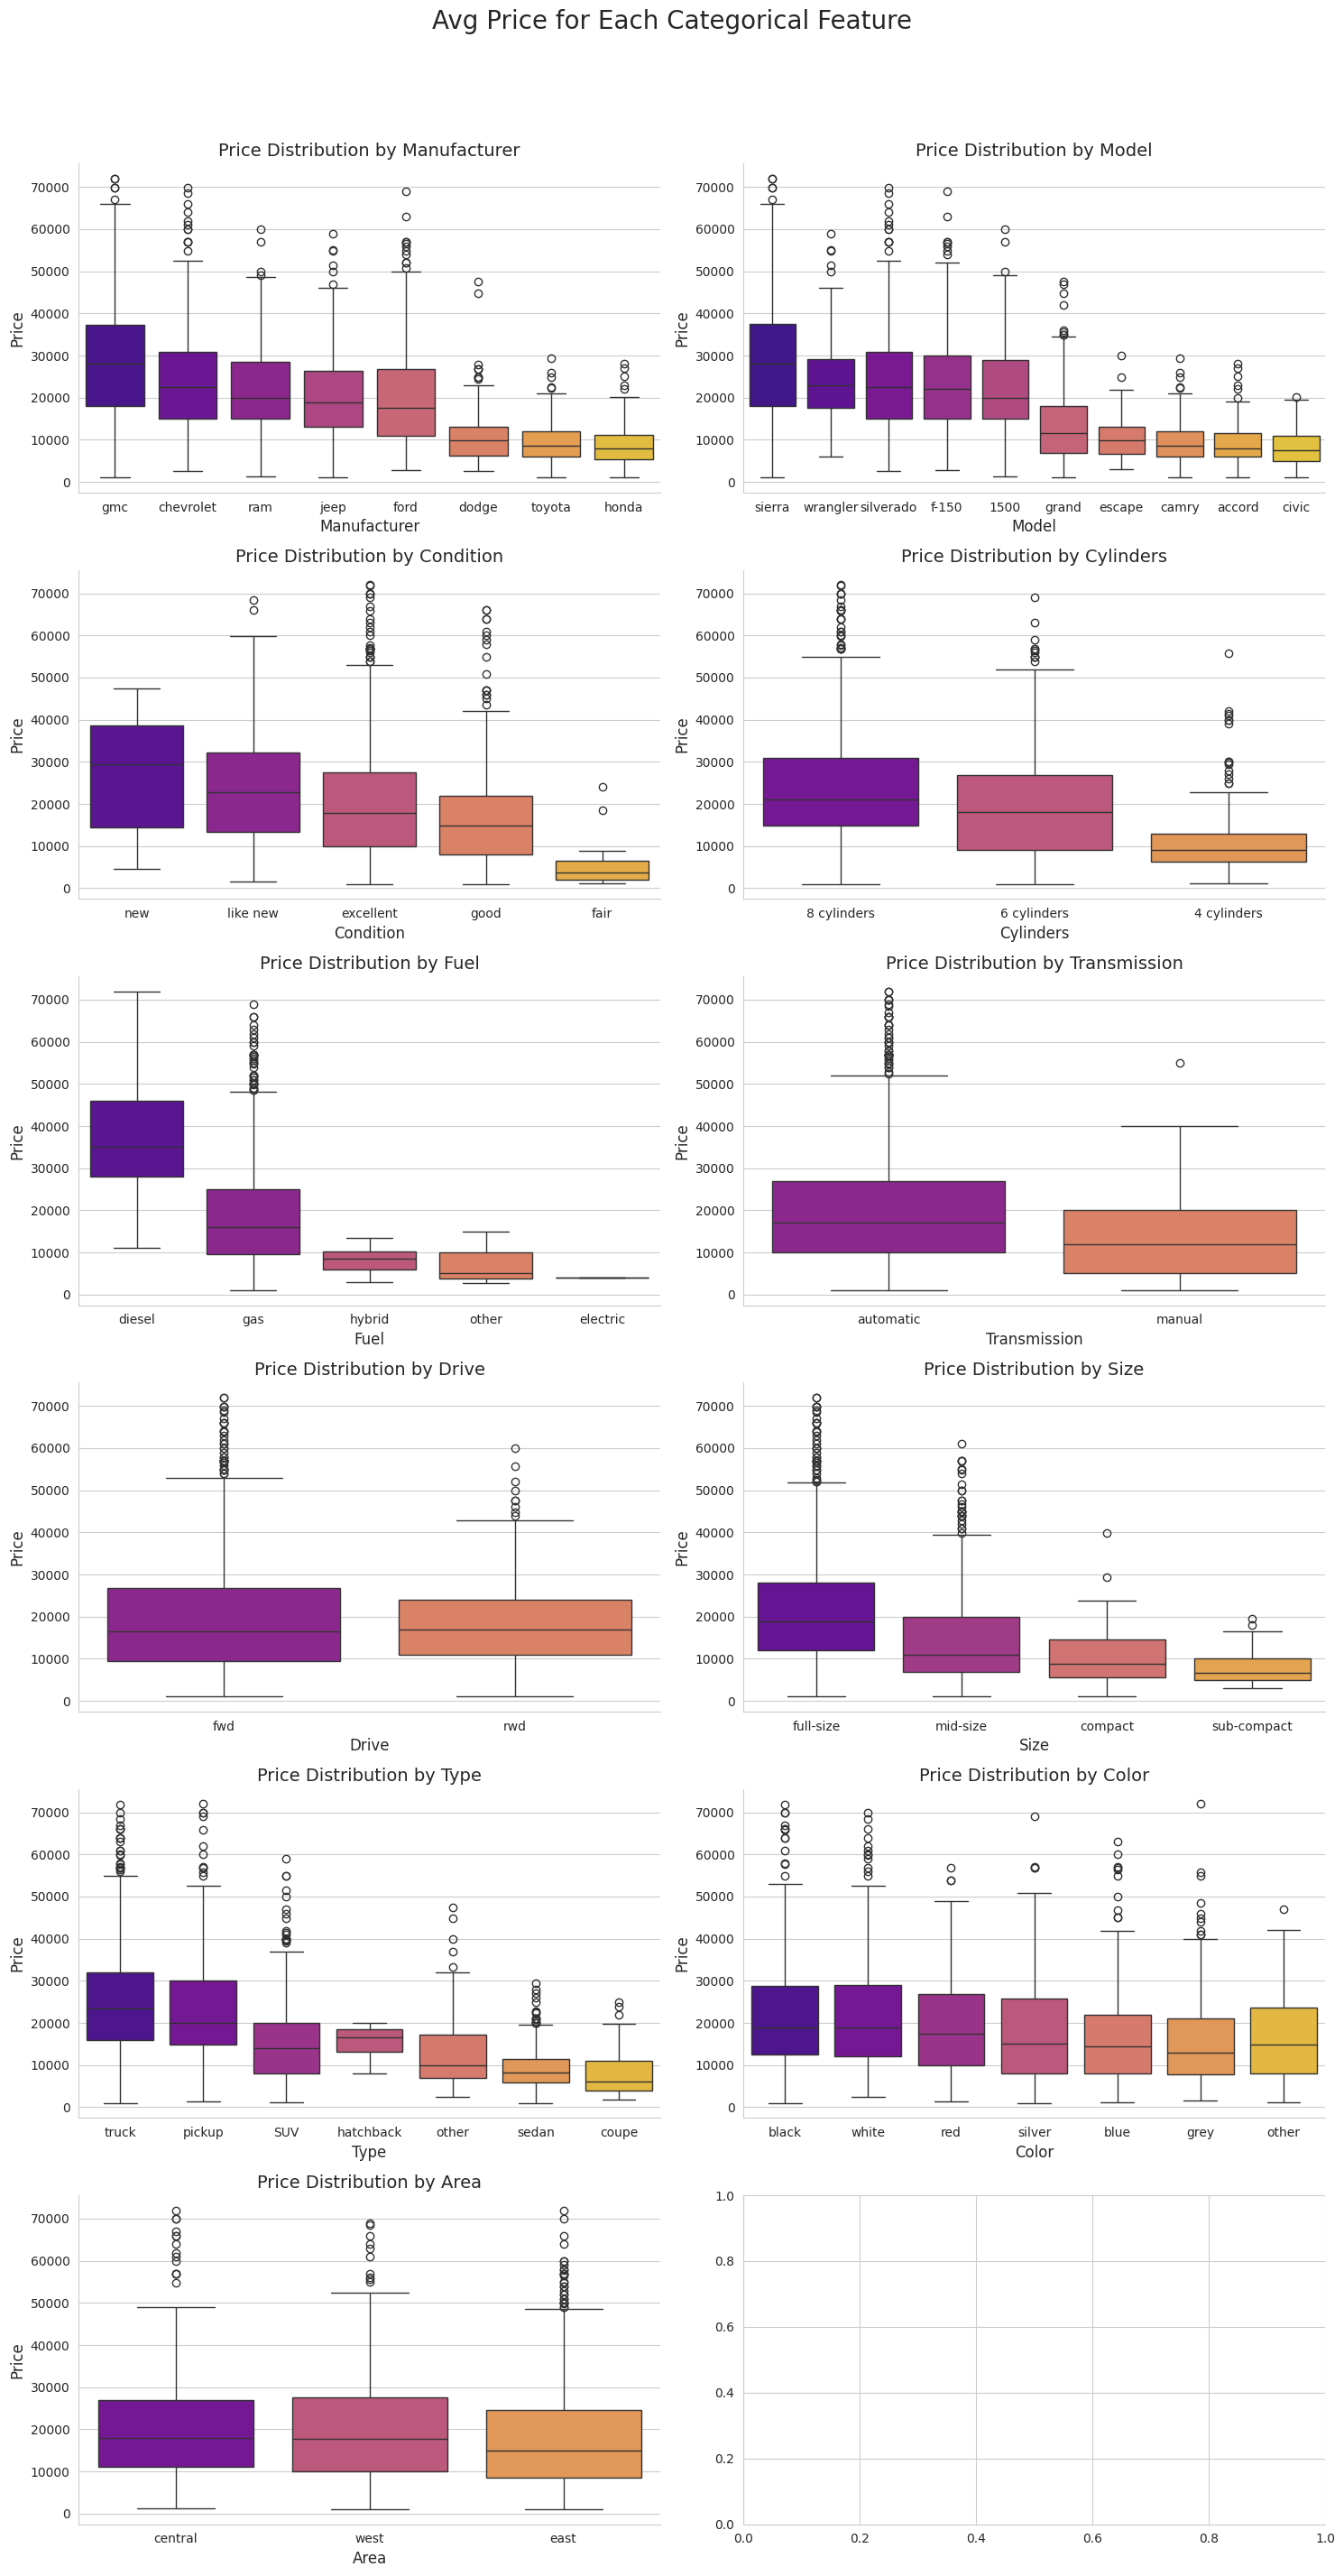

<Figure size 640x480 with 0 Axes>

In [46]:
categorical_cols = filtered_df.select_dtypes(include=['object']).columns

selected_cols = [col for col in categorical_cols ]

num_subplots = len(selected_cols)
num_rows = (num_subplots - 1) // 2 + 1
num_cols = min(2, num_subplots)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5), facecolor='white')
fig.suptitle("Avg Price for Each Categorical Feature", size=20)

# Create a color palette for these charts
colors = ['mediumvioletred']
for i in range(len(selected_cols)):
    colors.append('#%06X' % randint(0, 0xFFFFFF))


# Now create box plots that show the distribution of Price for each feature


for i in range(num_rows):
    for j in range(num_cols):
        idx = i * num_cols + j
        if idx < num_subplots:
            mean_values = filtered_df.groupby(selected_cols[idx])['price'].mean().sort_values(ascending=False)
            ax = sns.boxplot(x=selected_cols[idx], y='price', data=filtered_df, ax=axes[i, j],order=mean_values.index, palette=sns_palette_name)  #  [colors[idx]]
            axes[i, j].set_title(f'Price Distribution by {selected_cols[idx].title()}', fontsize=14)
            axes[i, j].set_xlabel(selected_cols[idx].title(), fontsize=12)
            axes[i, j].set_ylabel("Price", fontsize=12)
            axes[i, j].tick_params(axis='x')

sns.despine()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
plt.savefig("Avg Price for Each Categorical Feature.png", dpi=300)


### Box Plot Analysis
From the box plot, we can infer the following conclusions about the distribution of car prices with respect to different features:
#### Manufacturer:
 There is variation in price distribution among different manufacturers. Some manufacturers have a wider range of prices, while others have a more concentrated distribution, indicating that certain manufacturers may cater to different market segments.
#### Model:
 The price distribution varies significantly across different car models. Some models have a wide distribution, suggesting a range of options at different price points, while others are more concentrated.
#### Condition:
 Cars in excellent condition tend to have a higher median price and a wider distribution, indicating a range of prices within the 'excellent' category. Cars in lower condition categories have a more concentrated distribution, with lower median prices.
#### Transmission:
 Automatic transmission cars have a wider price distribution compared to manual transmission cars, which could suggest a higher demand or a greater variety of features and models available with automatic transmissions.
#### Drive:
 The distribution of prices for cars with different drive types (fwd, rwd) shows variation, with some drive types having a wider range of prices.
#### Size:
 Compact cars have a more concentrated price distribution, while full-size cars have a wider distribution, indicating a greater variety of price points within the full-size category.
#### Cylinders:
 The number of cylinders is associated with different price distributions. Cars with more cylinders tend to have a higher median price and a wider distribution, which may reflect higher performance or luxury models.
#### Type:
 Different car types (sedan, SUV, truck, etc.) have distinct price distributions, with some types having a wider range of prices, which could be due to differences in utility, features, and market demand.
#### Color:
 The distribution of prices also varies by color, with some colors having a wider distribution than others, which might reflect consumer preferences or the availability of certain colors in higher-end models.
#### Area:
 The area feature shows different price distributions, which could indicate regional variations in car prices due to factors like demand, economic conditions, or availability.
#### Odometer Range:
 Cars with different odometer readings show varying price distributions, with newer cars (lower odometer readings) generally having higher prices.

These insights from the box plot can be valuable for understanding the factors that influence car prices and can inform the feature selection and engineering process in machine learning model development. By identifying the features with the most significant impact on price, we can prioritize these for inclusion in the model to improve its predictive accuracy. Additionally, understanding the distribution of prices can help in detecting outliers and in transforming features to better capture the underlying patterns in the data

# Modeling

## Prepare Numerical and Categorical Columns

In [47]:
categorical_feature = df.dtypes==object
final_categorical_feature = filtered_df.columns[categorical_feature].tolist()

numeric_feature = df.dtypes!=object
final_numeric_feature = filtered_df.columns[numeric_feature].tolist()

In [48]:
df_dummy = pd.get_dummies(filtered_df, prefix=final_categorical_feature, columns=final_categorical_feature, drop_first=True)

X = df_dummy.drop("price", axis = 1)
y = df_dummy['price']


In [49]:
# Normalize the data
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

In [50]:
# Split the normalized data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

In [51]:
# scale the target variable
scale_target = MinMaxScaler()
y_train = pd.DataFrame(y_train)
y_train = scale_target.fit_transform(y_train)
y_test = pd.DataFrame(y_test)
y_test = scale_target.transform(y_test)

### Models to Test

The following regression models will be tested in a loop. After the modeling, we will evaluate the R2 and MSE to determine the best model that can be used to predict car prices.

*   Linear Regression
*   Ridge
*   LASSO
*   KNN
*   Random Forest



In [52]:
lm = LinearRegression()
ridge = Ridge(random_state = 100)
lasso = Lasso(random_state = 100)
knn = KNeighborsRegressor()
rf = RandomForestRegressor(random_state = 100)


algo = [ridge,knn,lasso, lm, rf]

result = []
ml_model = []

for i in algo:
        start = time.process_time()
        ml_model = i.fit(X_train,y_train)
        result.append([str(i).split("(")[0] + str("_baseline"), ml_model.score(X_train, y_train), ml_model.score(X_test, y_test),
                  np.sqrt(mean_squared_error(y_train, ml_model.predict(X_train))),
                  np.sqrt(mean_squared_error(y_test, ml_model.predict(X_test))),
                  mean_absolute_error(y_train, ml_model.predict(X_train)),
                  mean_absolute_error(y_test, ml_model.predict(X_test)),
                  r2_score(y_train,ml_model.predict(X_train)),
                  r2_score(y_test,ml_model.predict(X_test))])
        print(str(i).split("(")[0],"✓    ", "{}".format(round(time.process_time()-start,3)),"sec")
print()
print()
result = pd.DataFrame(result, columns = ["Algorithm", "Train_Score", "Test_Score", "Train_RMSE",
                                         "Test_RMSE", "Train_MAE", "Test_MAE", "Train_R2", "Test_R2"]).sort_values("Test_RMSE").set_index("Algorithm")
result

Ridge ✓     0.035 sec
KNeighborsRegressor ✓     0.289 sec
Lasso ✓     0.012 sec
LinearRegression ✓     0.19 sec
RandomForestRegressor ✓     1.045 sec




,Train_Score,Test_Score,Train_RMSE,Test_RMSE,Train_MAE,Test_MAE,Train_R2,Test_R2
Algorithm,,,,,,,,
RandomForestRegressor_baseline,0.978744,8.271537e-01,0.024609,7.198447e-02,0.015957,4.695805e-02,0.978744,8.271537e-01
Ridge_baseline,0.824623,7.845407e-01,0.070687,8.036951e-02,0.051906,5.603744e-02,0.824623,7.845407e-01
KNeighborsRegressor_baseline,0.733590,5.707519e-01,0.087122,1.134391e-01,0.062180,8.059997e-02,0.733590,5.707519e-01
Lasso_baseline,0.000000,-3.972940e-03,0.168792,1.734881e-01,0.134225,1.345489e-01,0.000000,-3.972940e-03
LinearRegression_baseline,0.742473,-2.850979e+23,0.085657,9.244975e+10,0.065742,3.945659e+09,0.742473,-2.850979e+23


 ### Evaluation of Model Scores
 To determine the best model, we should look for the one with the highest Test Score and Test R2, and the lowest Test RMSE and Test MAE, as these metrics indicate the model's performance on unseen data (the test set).
#### Best Score - Random Forest
The RandomForestRegressor_baseline model has the highest Test Score (0.827537) and Test R2 (0.827537), indicating it explains a significant proportion of the variance in the dependent variable. It also has relatively low Test RMSE (1.798447) and Test MAE (0.469585) compared to the other models, suggesting it has a good balance between bias and variance and is not overfitting as much as the other models might be.
#### Worst Score - Lasso
In contrast, the Lasso_baseline and LinearRegression_baseline models have negative Test R2 values, which are significantly worse than the other models, indicating poor performance on the test set. The Lasso_baseline model also has a Test Score of approximately -3972, which is an indicator of a model that performs worse than a simple mean model.
#### Conclusion
Therefore, the RandomForestRegressor_baseline model is the best model to predict price among the ones listed, as it has the best generalization performance on the test set according to the provided metrics.


## Features by Level of Importance From Last Model

The feature importance is used to identify those features that have the largest impact on the price.

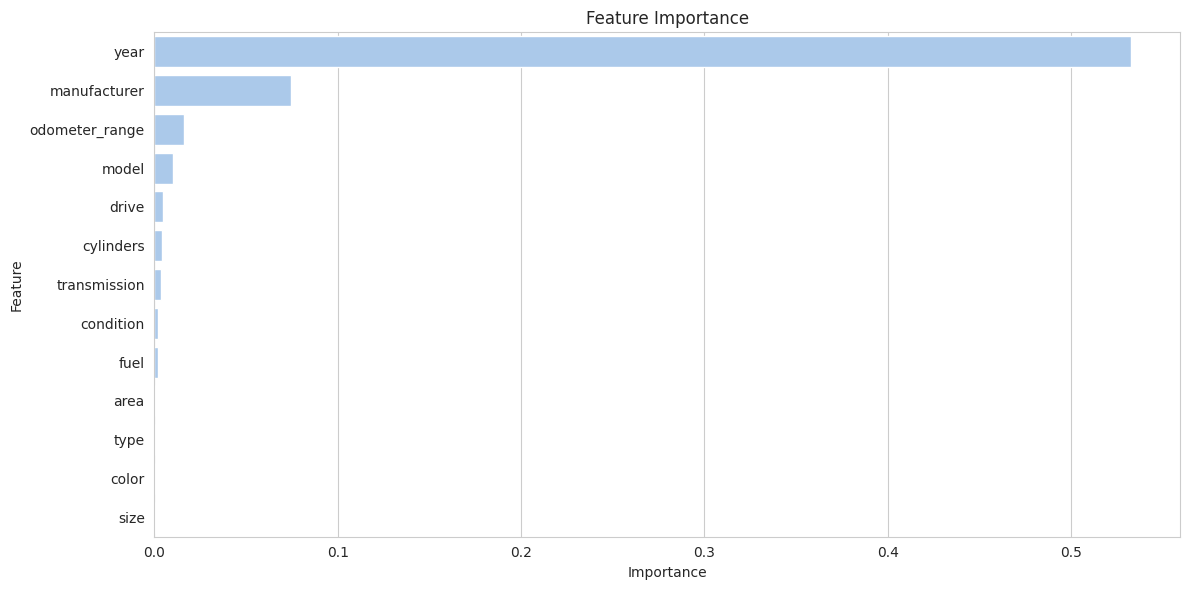

In [53]:
rankings = ml_model.feature_importances_.tolist()
noprice = df.drop(columns=['price'])
importance = pd.DataFrame(sorted(zip(noprice.columns,rankings),reverse=True),columns=["variable","importance"]).sort_values("importance",ascending = False)

plt.figure(figsize=(12,6))
sns.barplot(x="importance",
            y="variable",
            data=importance)

plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig("Feature Importance", dpi=300)

### Evaluate Feature Importance

From the Feature Importance Plot, we can infer the following conclusions:
#### Year:
 The 'year' feature has the highest importance, indicating that the model found the age of the vehicle to be the most significant predictor of the target variable. This suggests that newer or older vehicles could have a strong influence on the price.
#### Manufacturer:
 The 'manufacturer' is the second most important feature, which implies that the brand of the vehicle plays a crucial role in predicting its price. Different manufacturers may be associated with varying levels of quality, reputation, and market value, which can affect the price.
#### Odometer Range:
 The 'odometer_range' is also among the top three most important features, suggesting that the amount of mileage on a vehicle is a key factor in determining its price. Typically, vehicles with lower mileage may be priced higher due to less wear and tear.
#### Model:
 The 'model' of the vehicle is another important feature, indicating that specific models may have a significant impact on the price, possibly due to their market demand, features, or performance.
#### Drive:
 The 'drive' feature, which could refer to the type of drivetrain (e.g., front-wheel drive, rear-wheel drive), is also important, although less so than the top three features. This could reflect the performance characteristics or the intended use of the vehicle.
#### Cylinders:
 The number of cylinders, which is related to the engine size and power, shows moderate importance. This may affect the vehicle's performance and, consequently, its price.
#### Transmission:
 The 'transmission' type is also of moderate importance, with different transmission types potentially affecting the driving experience and price.
#### Condition:
 The 'condition' of the vehicle is relatively important, which is expected as the state of the vehicle can directly influence its value.
#### Fuel:
 The type of 'fuel' the vehicle uses is of lower importance compared to the top features but still contributes to the model's predictions.
#### Area:
 The 'area' feature has low importance, suggesting that the location of the vehicle sale may have a minor impact on the price.
#### Type, Color, Size:
 These features have the least importance in the model. While they do contribute to the predictions, their impact is relatively small compared to the other features.

This assessment can play a role in determining which cars should be considered by a Used Car lot. Selecting cars that have features with higher importance will translate to better sales.

## Polynomial Regression

### Degreee 2 and 3

In [54]:
# Polynomial regression of degree 2
model_degree_2 = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
model_degree_2.fit(X_train, y_train)

# Polynomial regression of degree 3
model_degree_3 = make_pipeline(PolynomialFeatures(degree=3), LinearRegression())
model_degree_3.fit(X_train, y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('linearregression', LinearRegression())])

### MSE and R2 of Polynomial Regressions

In [58]:
# Predictions
y_pred_degree_2 = model_degree_2.predict(X_test)
y_pred_degree_3 = model_degree_3.predict(X_test)

# Calculate mean squared error
mse_degree_2 = mean_squared_error(y_test, y_pred_degree_2)
mse_degree_3 = mean_squared_error(y_test, y_pred_degree_3)

# Calculate the R2 Score
r2_degree_2 = r2_score(y_test, y_pred_degree_2)
r2_degree_3 = r2_score(y_test, y_pred_degree_3)

print("MSE (degree 2):", mse_degree_2)
print("R-squared (degree 2):", r2_degree_2)
print()
print("MSE (degree 3):", mse_degree_3)
print("R-squared (degree 3):", r2_degree_3)

MSE (degree 2): 9.840996747761279e+20
R-squared (degree 2): -3.2826279095430986e+22

MSE (degree 3): 4.000255226230118e+20
R-squared (degree 3): -1.3343515690019781e+22


### Evaluate the Linear Regression Model

The Mean Squared Error (MSE) and the coefficient of determination (R2) are two commonly used metrics for determining the efficacy of a Polynomial Model.
#### Degree Comparison
##### MSE
The Degree 2 polynomial model has a slightly lower MSE than the Degree 3 model, indicating it has a marginally better fit in terms of the average squared errors.
##### R2
The Degree 2 model also has a less negative R2 value compared to the Degree 3 model, suggesting it does a slightly less poor job of explaining the variance in the dependent variable.

#### Conclusion
The Degree 2 polynomial model is marginally better than the Degree 3 model. However, both models exhibit signs of poor performance, and indicate that a Polynomial model is not the best model for predictions of this dataset.

### Summary

This Jupyter Notebook provides an analysis of various factors that influence used car prices, which is essential for a used car dealership to understand consumer preferences and inform pricing strategy. The analysis includes data cleaning and preprocessing to ensure the dataset's quality for reliable insights.

From the box plot analysis, it is evident that the distribution of car prices varies significantly across different features such as manufacturer, model, condition, transmission, drive, size, cylinders, type, color, area, and odometer range. For instance, cars from certain manufacturers have a wider price range, indicating a diverse market segment. Similarly, the condition of a car affects its price, with cars in excellent condition having a higher median price. The type of transmission also influences the price, with automatic cars having a wider distribution, possibly due to higher demand or more features.

The evaluation of model scores reveals that the RandomForestRegressor_baseline model is the most effective for predicting car prices, with the highest test score and R2 value, and relatively low test RMSE and MAE. In contrast, the Lasso_baseline and LinearRegression_baseline models perform poorly, with negative R2 values on the test set.The degree 2 polynomial model is marginally better than the degree 3 model, but both show signs of poor performance relative to the Random Forest Model.

The Feature Importance Plot indicates that the year of the vehicle is the most significant predictor of price, followed by the manufacturer and odometer range. Other features like the model, drive, cylinders, transmission, and condition also contribute to the prediction but to a lesser extent.

The Price Distribution plot shows a right-skewed distribution with a peak to the left of the mean price, suggesting that while most cars are priced around the mean, there is a significant number of higher-priced cars, possibly luxury or high-performance vehicles. The long tail towards higher prices indicates a smaller cluster of higher-priced cars.

In conclusion, the analysis provides valuable insights into the factors that influence car prices and highlights the importance of selecting features with higher importance for better sales predictions.

